In [1]:
#These are pip install commands, which will download all the libraries and tools you'll need for this project.
#Once you've installed these, you shouldn't have to keep re-running this cell.
!pip install kaggle
!pip install pandas
!pip install numpy
!pip install os
!pip install torch
!pip install torchvision
!pip install torch.optim
!pip install torch.utils.data
!pip install torchvision.transforms
!pip install PIL

  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
  Using cached charset_normalizer-3.4.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached certifi-2025.1.31-py3-none-any.whl (166 kB)
Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)
Using cached charset_normalizer-3.4.1-cp313-cp313-macosx_10_13_universal2.whl (195 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 34.0 MB/s eta 0:00:00a 

In [19]:
#from google.colab import drive
#drive.mount('/content/drive')
#These are the imports you will need for this project. If you find a tool from another library you want to use, you can import here.
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import time
import copy
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight

In [ ]:
#Set up your Kaggle account and add the JSON file into your Google Drive.
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/home/moddo/Kaggle/kaggle.json"
#We're downloading our modified brand dataset and unzipping it into our directory.
!kaggle datasets download -d aditikashi/stanford-car-dataset-brands-only-csv-files
!unzip stanford-car-dataset-brands-only-csv-files.zip

Traceback (most recent call last):
  File "/home/moddo/.local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/home/moddo/.local/lib/python3.10/site-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
  File "/home/moddo/.local/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
  File "/home/moddo/.local/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
KeyError: 'username'
unzip:  cannot find or open stanford-car-dataset-brands-only-csv-files.zip, stanford-car-dataset-brands-only-csv-files.zip.zip or stanford-car-dataset-brands-only-csv-files.zip.ZIP.


Training Dataset:
    imagename    label
0  00001.jpg     Audi
1  00002.jpg    Acura
2  00003.jpg    Dodge
3  00004.jpg  Hyundai
4  00005.jpg     Ford
Testing Dataset:
    imagename    label
0  00001.jpg   Suzuki
1  00002.jpg  Ferrari
2  00003.jpg     Jeep
3  00004.jpg   Toyota
4  00005.jpg    Tesla

Car brand distribution in training dataset:
 label
Chevrolet        905
Dodge            630
Audi             589
BMW              531
Ford             521
Hyundai          438
Mercedes-Benz    261
Chrysler         260
Acura            242
GMC              238
Bentley          238
Jeep             220
Nissan           171
Toyota           168
Suzuki           167
Ferrari          164
Honda            161
Lamborghini      161
Buick            158
Aston            157
Volkswagen       132
Volvo            131
Cadillac         129
Rolls-Royce      114
Spyker            88
Land              86
HUMMER            83
Bugatti           77
Infiniti          67
FIAT              62
Mitsubishi       

/var/folders/sj/4btlmy1j5fv3sb5mn3xt_4d80000gn/T/ipykernel_9298/2890319679.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sampled_df = train_df.groupby('label').apply(lambda x: x.sample(min(len(x), 3000 // train_df['label'].nunique()))).reset_index(drop=True)
/var/folders/sj/4btlmy1j5fv3sb5mn3xt_4d80000gn/T/ipykernel_9298/2890319679.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_sampl

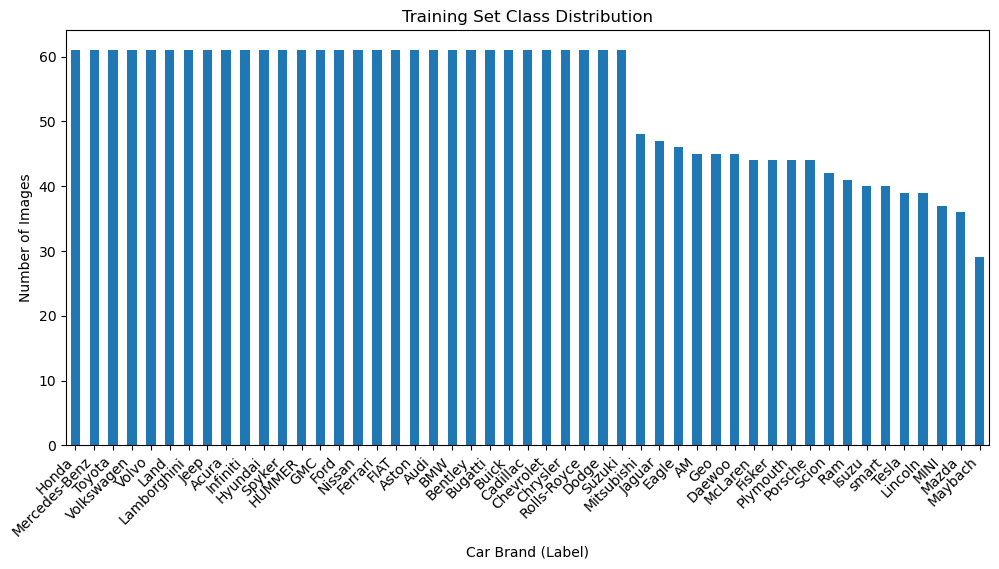

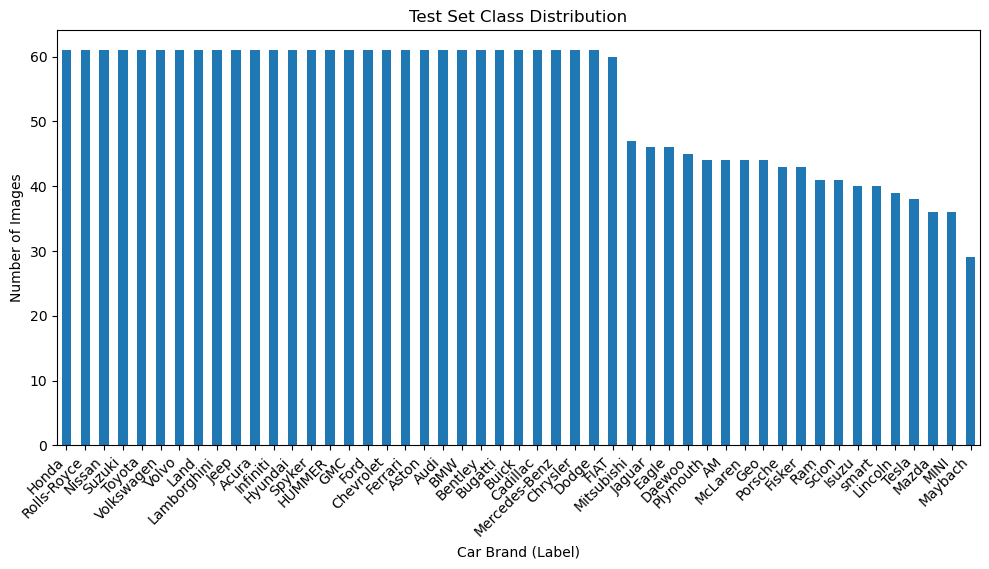

In [ ]:
#This line specify the paths to the CSV file and the image folder. Do NOT edit this, since it matches the imported dataset.
PATH = "cardata/"

#Create two pandas DataFrames that hold the info in the CSV files.
train_df = pd.read_csv(f'{PATH}train.csv')
test_df = pd.read_csv(f'{PATH}test.csv')

# Let's inspect the data!
print("Training Dataset:\n", train_df.head())
print("Testing Dataset:\n", test_df.head())

# Step 2: Check the distribution of car brands, a.k.a how many images of each brand there are.
print("\nCar brand distribution in training dataset:\n", train_df['label'].value_counts())
print("\nCar brand distribution in testing dataset:\n", test_df['label'].value_counts())

# Step 3: Take a random sampling of data. The reason we do this is because Jupyter Notebook can't efficiently run all 8000 training and 8000 testing images, so we have to
#have a smaller data set that can be run here. Don't worry about the semantics of this code, but all it's doing is taking 3000 sample images from each dataset. You can
#change the number 3000 to a different number if you'd like to test it out. We do this process for both training and testing data.
train_sampled_df = train_df.groupby('label').apply(lambda x: x.sample(min(len(x), 3000 // train_df['label'].nunique()))).reset_index(drop=True)
test_sampled_df = test_df.groupby('label').apply(lambda x: x.sample(min(len(x), 3000 // test_df['label'].nunique()))).reset_index(drop=True)

# Step 4: We can save these new datasets to new CSV files, new_train and new_test. The reason we made new files is in case we want to reaccess all of the data at any point.
#For model development, you'll be using these new CSV files.
train_sampled_df.to_csv('cardata/new_train.csv', index=False)
test_sampled_df.to_csv('cardata/new_test.csv', index=False)

#Let's inspect the size of the new datasets!
print("New Training Dataset shape:", train_sampled_df.shape)
print("New Testing Dataset shape:", test_sampled_df.shape)

#TO-DO: Move your new_train and new_test files into the cardata folder.
def plot_class_distribution(df, title="Class Distribution"):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Car Brand (Label)')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_class_distribution(train_sampled_df, title="Training Set Class Distribution")
plot_class_distribution(test_sampled_df, title="Test Set Class Distribution")

In [ ]:
#Okay, now it's time to work on our model! We've given you some of the basic code and function structure you'll need.
#This first section of code essentially reads, writes, and accesses our data. Don't worry about the functionality.

class CustomCarDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        #The three values below this comment are important!!
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        #Get a list of all the unique car brands for the classes.
        self.classes = self.labels_df['label'].unique().tolist()
        #Maps the labels to the indices.
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        try:
            #Get the image file name and label from the dataframe.
            img_name = os.path.join(self.img_dir, self.labels_df.iloc[idx, 0])
            #Open the image and convert to RGB.
            image = Image.open(img_name).convert('RGB')

            #Get the corresponding label and map it to the index
            label = self.class_to_idx[self.labels_df.iloc[idx, 1]]

            #Apply the transformations you created.
            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading index {idx}: {e}")
            return None  # or raise if you want to crash

#This is where you'll add your image augmentation. Refer back to the image augmentation notebook for some guidance.
#One function you'll definitely need is transforms.CenterCrop(). This is because the ResNet-50 model only uses images
#with inputs of size 244 by 244 (hint!). Another function you'll need is transforms.ToTensor(), since Tensorflow will only process data
#that is in tensor form. Finally, transforms.Normalize() is a way to standardize the images using ImageNet, which is typical
#for any models that were pre-trained using ImageNet, like ResNet50! Essentially, ResNet was originally trained on the images
#in ImageNet, so we adjust the range of our pixel values to match the range used in the ImageNet dataset.

#We've given you some of the functions you'll need, so it's your job to go through documentation and test out some code.

#DONE: Add the necessary functions we mentioned, and experiment with more image augmentation techniques that change more aspects of the images.
#Again, refer back to the image augmentation notebook for this. Try to see what combinations can increase your accuracy.

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # randomly zooms in
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.3081, 0.406], std=[0.229, 0.224, 0.225]),
])

#These are file paths for the CSV and the image directories.
train_img_dir = 'cardata/cars_train/'
train_csv = 'cardata/new_train.csv'

test_img_dir = 'cardata/cars_test/'
test_csv = 'cardata/new_test.csv'

#DONE: Create Dataset() instances here for the training and testing. Look at the def_init function at the very
#beginning that we have provided for you. Think about how you could call this class (CustomCardataset()) and what input values
#you might need to use. Hint: since this is a class, it won't be exactly like calling a function

train_dataset = CustomCarDataset(img_dir=train_img_dir, csv_file=train_csv, transform=transform)
test_dataset = CustomCarDataset(img_dir=test_img_dir, csv_file=test_csv, transform=transform)

#DONE: Create DataLoader() instances here for the training and testing. Documentation is your friend! Search for
#DataLoader documentation, and experiment with the parameters you give the function.



#DONE: Prepare dataloaders and dataset sizes for the training and testing phases.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#DONE:Get the class names (car brands) and the number of car brands.
all_brands = set(train_dataset.classes + test_dataset.classes)  # Merge train & test labels
num_classes = len(all_brands)

#TO-DO: Check if we can use torch.cuda for fast implementaiton or CPU.
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.labels_df['label']),
    y=train_dataset.labels_df['label']
)

# Map weights to index
weight_tensor = torch.tensor([class_weights[train_dataset.class_to_idx[c]] for c in train_dataset.classes], dtype=torch.float).to(device)


#Here's where you'll be implementing your model. Again, documentation, Google, and ChatGPT is your friend.
#We'll leave in variable names so you have a general idea of what to follow and so that the code flows with the
#pre-written aspects.

#DONE: Here is where you set the model to ResNet-50. Look at some of the parameters you might need.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.fc.in_features, num_classes)
)

#DONE: Here is where you will add some of the features of the model, like the loss function, optimizer, and learning
#rate scheduler. You can use whatever features you'd like, and keep experimenting with different hyperparameters to
#see what works best. Once again, look at documentation!

criterion = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.1)

optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Modify the fully connected layer to match the number of car brands (hint: where did we get the number of car brands?).


model = model.to(device)
print(next(model.parameters()).device)
#This section of the code creates the training and testing pipeline. While this is an important part of the computer vision
#pipeline, it mainly involves iterating over data and finding accuracy, which are not as critical to your fundamental
#understanding of computer vision as a whole. We've given you the code that will iterate through your model. Feel free to change
#or add anything you'd like (hint: you can look into things like freezing a layer, adding a layer, etc).

#TO-DO: Experiment as much as you'd like with adding layers, freezing layers, anything you'd like to try.
def make_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()

    ##DONE: Save the best model and best accuracy.
    
    best_acc = 0.0
    best_model = model.state_dict()
    dataloaders = {'train': train_loader, 'test': test_loader}

    for epoch in range(num_epochs):
        ##DONE: Print which epoch you are on.
        
        print(f'Epoch: {epoch}/{num_epochs - 1}')

        if epoch == 5:
            print("Unfreezing layer3 for fine-tuning")
            for name, param in model.named_parameters():
                if "layer3" in name:
                    param.requires_grad = True

            # Rebuild optimizer with new trainable params
            optimizer = torch.optim.SGD(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=0.005,
                momentum=0.9,
                weight_decay=5e-4
            )
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            runningLoss = 0.0       
            runningCorrect = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the parameter gradients.
                optimizer.zero_grad()
                # This is a place where you could add more features, like cross-validation, freezing, etc.
                
                # Forward pass: run through the model forwards.
                outputs = model(inputs)
                # Backward pass + optimize: this only happens while in train mode.
                loss = criterion(outputs,labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # Calculate running loss function and the number of correct guesses.
                runningLoss += loss.item()
                _, preds = torch.max(outputs, 1)
                runningCorrect += torch.sum(labels.data == preds)
            
            # Calculate and print epoch loss, and continue training if it is the appropriate phase.
            print(f'Epoch: {epoch+1}, Loss: {runningLoss/len(train_loader)}')
            if phase == 'train':
                epoch_acc = runningCorrect / len(train_dataset)
                print(f"Training accuracy: {epoch_acc}")
                scheduler.step(runningLoss/len(train_loader))
                torch.save(model.state_dict(), 'car_brand_model.pth')
            else:
                epoch_acc = runningCorrect / len(test_dataset)
                print(f"Testing accuracy: {epoch_acc}")

                # Calculate testing auroc
                all_labels = []
                all_probs = []

                with torch.no_grad():
                    for inputs, labels in dataloaders["test"]:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        probs = F.softmax(outputs, dim=1)

                        all_labels.extend(labels.cpu().numpy())
                        all_probs.extend(probs.cpu().numpy())

                try:
                    epoch_auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
                    print(f"Testing AUROC (macro, OVR): {epoch_auroc:.4f}")
                except ValueError as e:
                    print(f"Could not compute AUROC: {e}")
            #TO-DO: Make a deep copy of the best model and update accuracy.
        
        if phase == 'test':
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_copy = copy.deepcopy(model.state_dict())
                
                        
    # Check how much time training took.
    time_elapsed = time.time() - since
    # Load the best model weights for the next epoch.
    model.load_state_dict(best_model_copy)
    return model
#TO-DO: Write this function that calls the training function with all its parameters.
try:
    modelf = make_model(model,criterion, optimizer,scheduler)
    torch.save(modelf.state_dict(), 'car_brand_model.pth')
except Exception as e:
    print(f"Error {e}")

mps:0
Epoch: 0/24
Epoch: 1, Loss: 3.541861275592482
Training accuracy: 0.14438095688819885
Epoch: 1, Loss: 3.257675022964018
Testing accuracy: 0.2894837558269501
Testing AUROC (macro, OVR): 0.8917
Epoch: 1/24
🔓 Unfreezing layer3 for fine-tuning
Epoch: 2, Loss: 2.3297515059091958
Training accuracy: 0.46971428394317627
Epoch: 2, Loss: 2.2764840521008134
Testing accuracy: 0.49407264590263367


KeyboardInterrupt: 